<a href="https://colab.research.google.com/github/neuralsrg/SequenceModels/blob/main/transformers/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer (from [Ashish Vaswani paper](https://arxiv.org/pdf/1706.03762.pdf)) implementation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 0. Overview


![image](https://i.imgur.com/7tnXkVG.png)

## 1. Positional encoding

$$
PE_{(pos, 2i)} = sin(\frac{pos}{10,000^{\frac{2i}{d_{model}}}})
$$
$$
PE_{(pos, 2i+1)} = cos(\frac{pos}{10,000^{\frac{2i}{d_{model}}}})
$$

In [2]:
def positional_encoding(num_positions : int, encoding_dim : int):

  flt = np.vectorize(lambda x: x if x % 2 == 0 else x - 1)
  denom = flt(np.arange(encoding_dim, dtype=int))
  denom = 10000 ** (denom / encoding_dim)

  positions = [position / denom for position in range(num_positions)]
  positions = np.stack(positions, axis=0)
  positions[:, ::2] = np.sin(positions[:, ::2])
  positions[:, 1::2] = np.cos(positions[:, 1::2])

  return tf.cast(positions[np.newaxis, ...], dtype=tf.float32) # (1, positions, encoding_dim)

### 1.1 Visualize

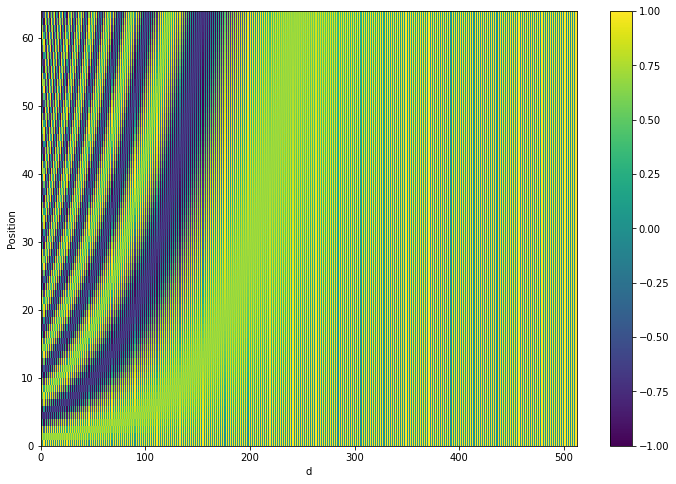

In [ ]:
plt.figure(figsize=(12, 8))
plt.pcolormesh(positional_encoding(64, 512)[0])
plt.xlabel('d')
plt.ylabel('Position')
plt.colorbar()

## 2. Masks



### 2.1 Padding mask

All the sequences passed to Transformer are of the same length. Hence, some of them are padded with zeros. But for softmax it is better if the logits are close to negative infinity rether than equal to zero. That's what `padding mask` does

In [3]:
def create_padding_mask(seq):
  """
  Creates a matrix mask for the padding cells
  
  Arguments:
    seq -- (n, m) matrix
  
  Returns:
    mask -- (n, 1, 1, m) binary tensor
  """
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :] 

### 2.2 Look-ahead mask

It is used in Multi-Head Attention

In [4]:
def create_look_ahead_mask(size):
  """
  Returns an upper triangular matrix filled with ones
  
  Arguments:
    size -- matrix size
  
  Returns:
    mask -- (size, size) tensor
  """
  return tf.linalg.band_part(tf.ones((size, size)), -1, 0)

In [ ]:
tf.linalg.band_part(tf.ones((3, 3)), -1, 0)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

Given that the model has correctly predicted label $i$, we want to check wether it will predict label $i+1$

## 3. Scaled Dot-Product Attention

$$
Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}} + M)V
$$


![image](https://i.imgur.com/3CfFY37.png)

In [5]:
def scaled_dot_product_attention(Q, K, V, M=None):
  dk = tf.cast(K.shape[-1], tf.float32)
  scaled = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(dk)

  if M is not None:
    scaled += (M * -1e9)

  attention_weights = tf.nn.softmax(scaled, axis=-1)
  output = tf.matmul(attention_weights, V)

  return output, attention_weights

## 4. Encoder

The `encoder` is composed of a stack of $N = 6$ identical layers. Each layer has two sub-layers. The first is a `multi-head self-attention` mechanism, and the second is a simple, positionwise `fully connected feed-forward` network. We employ a `residual connection` around each of the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is $LayerNorm(x + Sublayer(x))$, where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model}$ = 512.

In [6]:
class EncoderLayer(tf.keras.layers.Layer):

  def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
    super(EncoderLayer, self).__init__()

    self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                  key_dim=embedding_dim)

    self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    
  def call(self, x, training, mask):
    """
    Forward pass for the Encoder Layer
    
    Arguments:
        x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        training -- Boolean, set to true to activate
                    the training mode for dropout layers
        mask -- Boolean mask to ensure that the padding is not 
                treated as part of the input
    Returns:
        out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
    """
    self_attn_output = self.mha(x, x, x, mask) # Self attention (batch_size, input_seq_len, embedding_dim)
    self_attn_output = self.dropout1(self_attn_output, training=training)
    
    # with Layer Normalization the normalization happens across the axes within
    # each example, rather than across different examples in the batch
    mult_attn_out = self.layernorm1(x + self_attn_output)

    ffn_output = self.ffn(mult_attn_out)
    ffn_output = self.dropout2(ffn_output, training=training)
    encoder_layer_out = self.layernorm2(ffn_output + mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
    
    return encoder_layer_out

In [7]:
class Encoder(tf.keras.layers.Layer):
  """
  Embedding -> Positional encoding -> N * EncoderLayer
  """   
  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
    super(Encoder, self).__init__()

    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.embedding_dim)

    self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                    num_heads=num_heads,
                                    fully_connected_dim=fully_connected_dim,
                                    dropout_rate=dropout_rate,
                                    layernorm_eps=layernorm_eps) 
                        for _ in range(self.num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
      

  def call(self, x, training, mask):
    """
    Forward pass for the Encoder
    
    Arguments:
      x -- Tensor of shape (batch_size, input_seq_len)
      training -- Boolean, set to true to activate
                  the training mode for dropout layers
      mask -- Boolean mask to ensure that the padding is not 
              treated as part of the input
    Returns:
      out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
    """

    seq_len = tf.shape(x)[1]
    
    x = self.embedding(x)
    # Scale embedding
    x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
        x = self.enc_layers[i](x,training, mask)

    return x

## 5. Decoder

The decoder is also composed of a stack of $N = 6$ identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs `multi-head attention` over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by `layer normalization`. We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [10]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self, embedding_dim, num_heads, fully_connected_dim,
              dropout_rate=0.1, layernorm_eps=1e-6):
    super(DecoderLayer, self).__init__()

    self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=embedding_dim)

    self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=embedding_dim)

    self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
  

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    """
    Forward pass for the Decoder Layer
    
    Arguments:
      x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
      enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
      training -- Boolean, set to true to activate
                  the training mode for dropout layers
      look_ahead_mask -- Boolean mask for the target_input
      padding_mask -- Boolean mask for the second multihead attention layer
    Returns:
      out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
      attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
      attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
    """
    
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask,
                                          return_attention_scores=True)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output,
                                          padding_mask, return_attention_scores=True)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)
    
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 =  self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, embedding_dim)

    return out3, attn_weights_block1, attn_weights_block2

In [11]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
              maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
    super(Decoder, self).__init__()

    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

    self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                    num_heads=num_heads,
                                    fully_connected_dim=fully_connected_dim,
                                    dropout_rate=dropout_rate,
                                    layernorm_eps=layernorm_eps) 
                        for _ in range(self.num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
  
  def call(self, x, enc_output, training, 
          look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
    
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
      attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
    
    return x, attention_weights

## 6. Transformer


In [14]:
class Transformer(tf.keras.Model):
  
  def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
              target_vocab_size, max_positional_encoding_input,
              max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
    super(Transformer, self).__init__() 
    self.encoder = Encoder(num_layers=num_layers,
                            embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            fully_connected_dim=fully_connected_dim,
                            input_vocab_size=input_vocab_size,
                            maximum_position_encoding=max_positional_encoding_input,
                            dropout_rate=dropout_rate,
                            layernorm_eps=layernorm_eps)

    self.decoder = Decoder(num_layers=num_layers, 
                            embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            fully_connected_dim=fully_connected_dim,
                            target_vocab_size=target_vocab_size, 
                            maximum_position_encoding=max_positional_encoding_target,
                            dropout_rate=dropout_rate,
                            layernorm_eps=layernorm_eps)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

  
  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    """
    Forward pass for the entire Transformer
    Arguments:
        inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
        training -- Boolean, set to true to activate
                    the training mode for dropout layers
        enc_padding_mask -- Boolean mask to ensure that the padding is not 
                treated as part of the input
        look_ahead_mask -- Boolean mask for the target_input
        padding_mask -- Boolean mask for the second multihead attention layer
    Returns:
        final_output -- Describe me
        attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                            each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
    
    """
    enc_output = self.encoder(inp,training,enc_padding_mask)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)

    return final_output, attention_weights